In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os

In [30]:
def load_sensor_data(filename):
    df = pd.read_csv(f'../Data/raw_data/{filename}', sep=',')

    # Split the data into columns
    df[['Cycle','Position','Reading']] = df['Data'].str.split(':', expand=True)
    df.drop(columns=['Data','Index'], inplace=True)

    # Clean 
    df.dropna(inplace=True)

    # Convert the data types
    df['Cycle'] = df['Cycle'].astype(int)
    df['Position'] = df['Position'].astype(int)
    df['Reading'] = df['Reading'].astype(float)

    df['Position_Gradient'] = np.gradient(df['Position'])
    df['Direction'] = df['Position_Gradient'] > 0

    # print(df.tail())
    print(f"Data loaded from {filename}")

    return df

In [31]:
df = None
df_split = None
df_plot = None

file_name = 'data_filmed_0204_220747.csv'

# List files in the directory
files = os.listdir('../Data/raw_data')
# List files in the directory sorted by creation date
files = sorted(os.listdir('../Data/raw_data'), key=lambda x: os.path.getctime(os.path.join('../Data/raw_data', x)))

# Create a dropdown widget
file_dropdown = widgets.Dropdown(
    options=files,
    description='Select File:',
    disabled=False,
)

# Display the dropdown widget
display(file_dropdown)

df = load_sensor_data(files[-1])

# Update the file_name based on the selection
def on_file_change(change):
    global file_name, df
    file_name = change['new']

    df = load_sensor_data(file_name)

file_dropdown.observe(on_file_change, names='value')

Dropdown(description='Select File:', options=('cycle_test(output).csv', 'data_0123_211343.csv', 'data_0123_212…

Data loaded from data_filmed_0204_230101.csv


Data loaded from data_filmed_0204_230101.csv
Data loaded from data_filmed_0204_225150.csv


Text(0, 0.5, 'Resistance (ADC Value)')

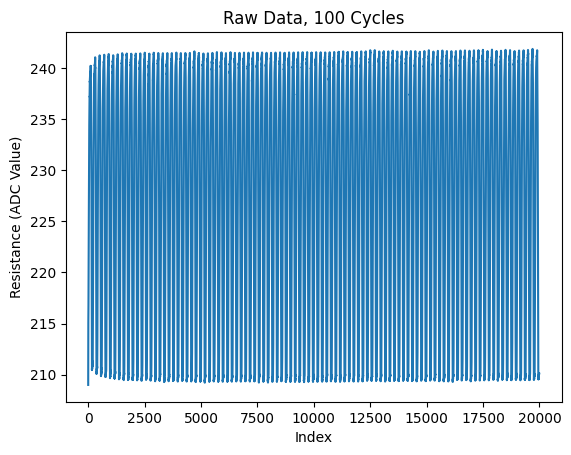

In [32]:
# df.plot(x='Cycle', y='Reading',c='Position',colormap='jet', kind='scatter')
# plt.scatter(df.index, df['Reading'], c=df['Position'], cmap='viridis',s=3)
plt.plot(df.index, df['Reading'])
plt.title('Raw Data, 100 Cycles')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')

,Cycle,Position,Reading,Position_Gradient,Direction
1,0,-1,209.00,-6.0,False
2,0,-7,214.29,-6.0,False
3,0,-13,214.37,-6.5,False
4,0,-20,214.67,-6.5,False
5,0,-26,214.63,-6.5,False


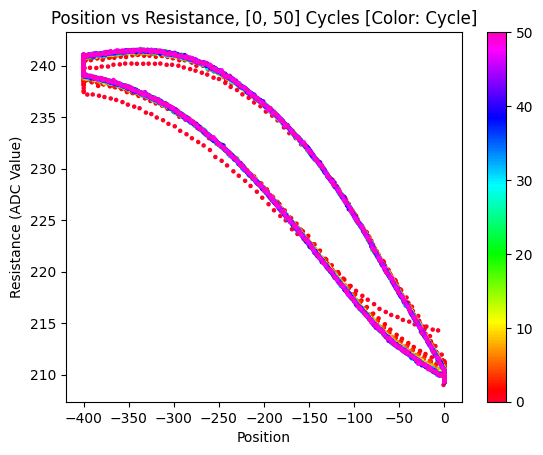

In [49]:
bounds = [0,50]
df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='gist_rainbow',s=5)
plt.title(f'Position vs Resistance, {bounds} Cycles [Color: Cycle]')
plt.xlabel('Position')
plt.ylabel('Resistance (ADC Value)')
plt.colorbar()
df_plot.head()

In [52]:
files[-6:-1]

['data_filmed_0204_220747.csv',
 'data_filmed_0204_222317.csv',
 'data_filmed_0204_223327.csv',
 'data_filmed_0204_224239.csv',
 'data_filmed_0204_225150.csv']

In [63]:
def plot_pr_curve(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    plt.scatter(df_plot['Position'], df_plot['Reading'], c=df_plot['Cycle'], cmap='gist_rainbow',s=5)
    plt.title(f'Position vs Resistance, {bounds} Cycles [Color: Cycle]')
    plt.xlabel('Position')
    plt.ylabel('Resistance (ADC Value)')
    plt.colorbar()

def plot_data(df, bounds):
    df_plot = df[(df['Cycle'] >= bounds[0]) & (df['Cycle'] <= bounds[1])]
    df_plot2 = df_plot[(df_plot['Position'] == -400) | (df_plot['Position'] == 0)]
    plt.plot(df_plot.index, df_plot['Reading'])
    plt.scatter(df_plot2.index, df_plot2['Reading'], c=df_plot2['Position'], cmap='viridis',s=5)
    plt.title('Raw Data, 100 Cycles')
    plt.xlabel('Index')
    plt.ylabel('Resistance (ADC Value)')
    plt.show()


Data loaded from data_filmed_0204_220747.csv


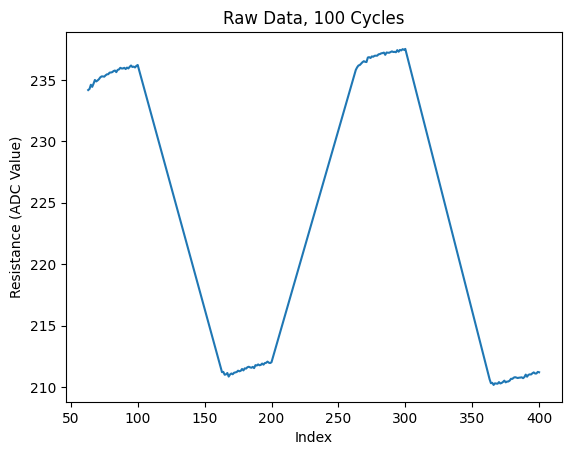

Data loaded from data_filmed_0204_222317.csv


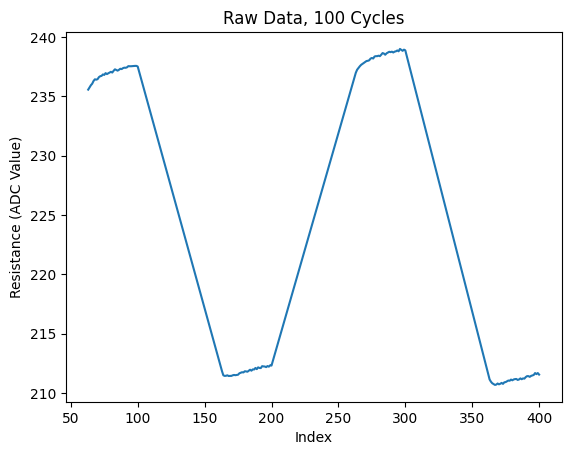

Data loaded from data_filmed_0204_223327.csv


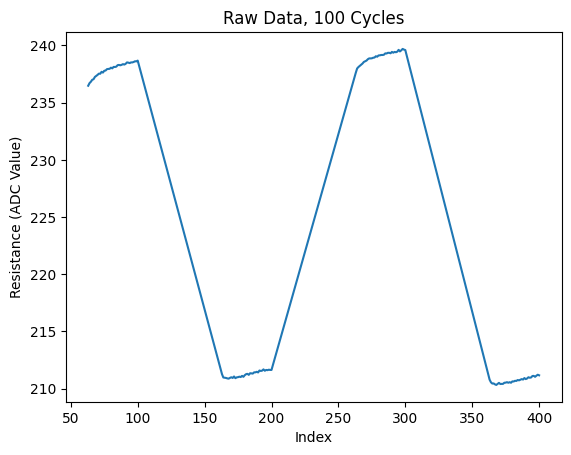

Data loaded from data_filmed_0204_224239.csv


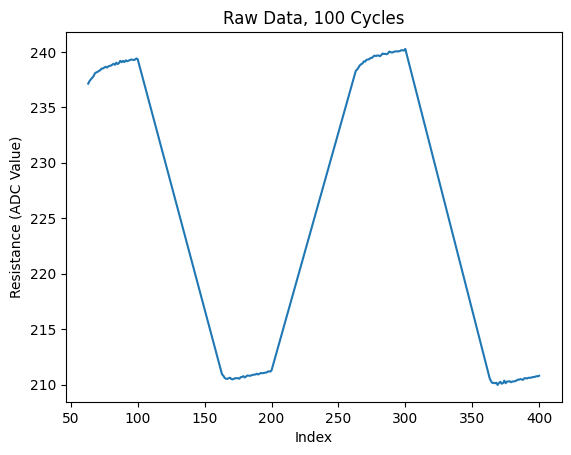

Data loaded from data_filmed_0204_225150.csv


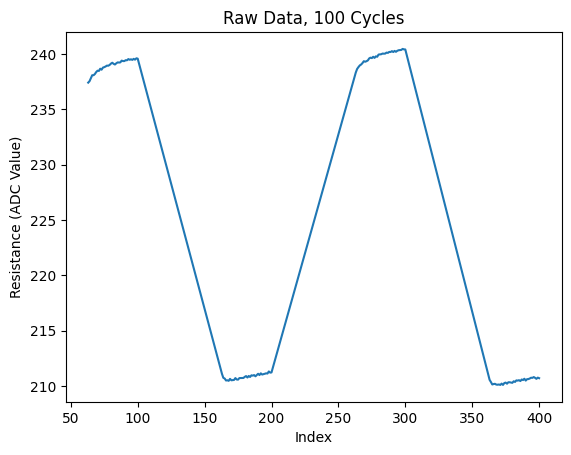

In [66]:
for file in files[-6:-1]:
    df = load_sensor_data(file)
    plot_data(df, [0,1])
    plt.show()

Data loaded from data_filmed_0204_220747.csv
Data loaded from data_filmed_0204_222317.csv
Data loaded from data_filmed_0204_223327.csv
Data loaded from data_filmed_0204_224239.csv
Data loaded from data_filmed_0204_225150.csv


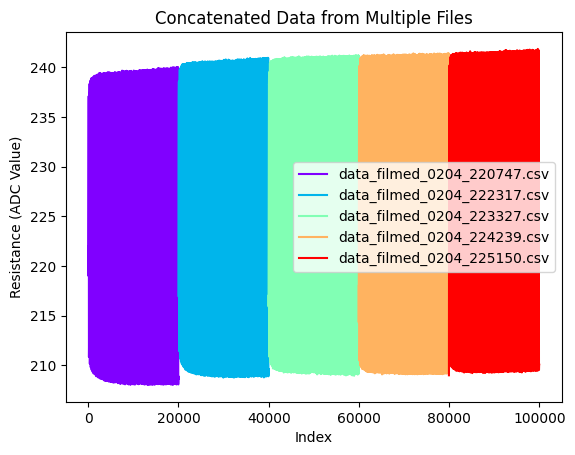

In [ ]:

df_concat = pd.DataFrame()

colors = plt.cm.rainbow(np.linspace(0, 1, len(files[-6:-1])))

for i, file in enumerate(files[-6:-1]):
    df = load_sensor_data(file)
    df['Index_Offset'] = df.index + len(df_concat)
    df_concat = pd.concat([df_concat, df])
    plt.plot(df['Index_Offset'], df['Reading'], color=colors[i], label=file)


plt.title('Concatenated Data from Multiple Files')
plt.xlabel('Index')
plt.ylabel('Resistance (ADC Value)')
plt.legend()
plt.show()